#<div align="center">Project Machine Learning</div>
## <div align="center">Analisis Sentimen Terkait Chat GPT pada Platform X dengan Menggunakan Metode Naive Bayes</div>
#### <div align="center"> </div>
<br>


*   Evan Lo 




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from imblearn.under_sampling import NearMiss
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Evanlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Evanlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Evanlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('file.csv')
df.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  219294 non-null  int64 
 1   tweets      219294 non-null  object
 2   labels      219294 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


In [4]:
df.isna().sum()

Unnamed: 0    0
tweets        0
labels        0
dtype: int64

In [5]:
df.shape

(219294, 3)

In [6]:
df = df.dropna()
df.isna().sum()

Unnamed: 0    0
tweets        0
labels        0
dtype: int64

In [7]:
df = df[['labels','tweets']]
df.head()

,labels,tweets
0,neutral,ChatGPT: Optimizing Language Models for Dialog...
1,good,"Try talking with ChatGPT, our new AI system wh..."
2,neutral,ChatGPT: Optimizing Language Models for Dialog...
3,good,"THRILLED to share that ChatGPT, our new model ..."
4,bad,"As of 2 minutes ago, @OpenAI released their ne..."


In [8]:
df['tweets']

0         ChatGPT: Optimizing Language Models for Dialog...
1         Try talking with ChatGPT, our new AI system wh...
2         ChatGPT: Optimizing Language Models for Dialog...
3         THRILLED to share that ChatGPT, our new model ...
4         As of 2 minutes ago, @OpenAI released their ne...
                                ...                        
219289    Other Software Projects Are Now Trying to Repl...
219290    I asked #ChatGPT to write a #NYE Joke for SEOs...
219291    chatgpt is being disassembled until it can onl...
219292    2023 predictions by #chatGPT. Nothing really s...
219293     From ChatGPT, neat stuff https://t.co/qjjUF2Z2m0
Name: tweets, Length: 219294, dtype: object

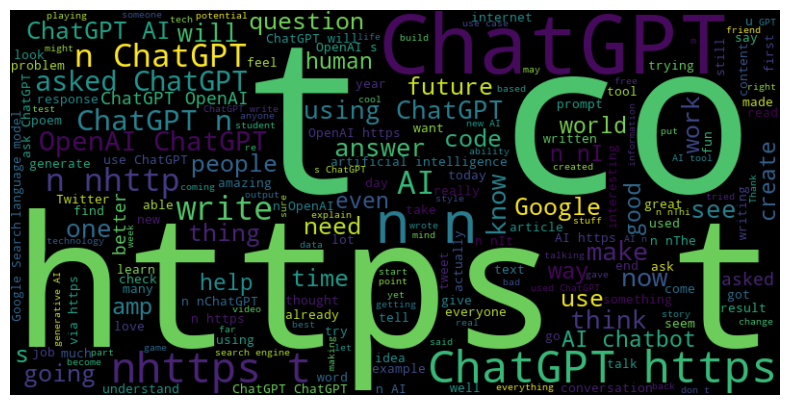

In [9]:
df['tweets'] = df['tweets'].astype(str)

text_df = df['tweets'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400).generate(text_df)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
df['labels'].value_counts()

labels
bad        107796
good        56011
neutral     55487
Name: count, dtype: int64

In [11]:
class_pos = df[df['labels'] == 'good']
class_net = df[df['labels'] == 'neutral']
class_neg = df[df['labels'] == 'bad']

class_neg = class_neg.iloc[:25000]
class_pos = class_pos.iloc[:25000]
class_net = class_net.iloc[:25000]

df = pd.concat([class_pos,class_net,class_neg])
df['labels'].value_counts()




labels
good       25000
neutral    25000
bad        25000
Name: count, dtype: int64

In [12]:
stop_words = set(stopwords.words('english'))
WNL = WordNetLemmatizer()

# menghilankan emoji
def remove_emojis_and_patterns(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002500-\U00002BEF"
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    # mendefinisikan pattern nya
    additional_pattern = r'["\'!?\*@$#%^A&,;:<>\\/()]+|\bhttps?://\S+\b|\bvl\b|\bnhttps\b|\bt\.co\b|\bzp7hniuxbu\b|\bnhttps\b|\bnisjlwhomw\b|\bzp7hniuxbunisjlwhomw\b'
    combined_pattern = f"{emoji_pattern.pattern}|{additional_pattern}"

    return re.sub(combined_pattern, '', text)


def is_alpha(word):
    for part in word.split('-'):
        if not part.isalpha():
            return False
    return True


def clean_dataset(text):
    text = remove_emojis_and_patterns(text)
    #  menghilangkan link, special char, dan convert huruf kecil
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'\\n', ' ', text) 
    text = re.sub(r"\s*#\S+", "", text) 
    text = text.lower()
    
    # Tokenisasi kata dan lemmatize
    words = [word for word in word_tokenize(text) if is_alpha(word)]
    words = [WNL.lemmatize(word) for word in words]
    
    # menghilangkan Stopword
    words = [w for w in words if not w in stop_words]
    
    # Gabungin teks nya
    text = " ".join(words)
    
    return text.strip()

# Implementasi
df['tweets'] = df['tweets'].apply(clean_dataset)
df.head()

,labels,tweets
1,good,try talking chatgpt new system optimized dialo...
3,good,thrilled share chatgpt new model optimized dia...
5,good,launched chatgpt new system optimized dialogue
7,good,chatgpt coming strong refusing help stalk some...
8,good,deployed thing ive helping build last couple m...


In [13]:
df['tweets'] = df['tweets'].str.split()
print(df['tweets'])
#pisahkan string

1        [try, talking, chatgpt, new, system, optimized...
3        [thrilled, share, chatgpt, new, model, optimiz...
5        [launched, chatgpt, new, system, optimized, di...
7        [chatgpt, coming, strong, refusing, help, stal...
8        [deployed, thing, ive, helping, build, last, c...
                               ...                        
51869    [building, fantaclaus, fantaclaus, openai, cha...
51870    [people, saying, chatgpt, replace, google, thi...
51871    [open, ha, released, new, chatgpt, model, ml, ...
51872    [chatgpt, trained, tensorflow, nyways, answer,...
51873    [ive, ask, chatgpt, write, basic, rest, pi, ru...
Name: tweets, Length: 75000, dtype: object


In [14]:
df.values[:5].tolist()

[['good',
  ['try',
   'talking',
   'chatgpt',
   'new',
   'system',
   'optimized',
   'dialogue',
   'feedback',
   'help',
   'u',
   'improve']],
 ['good',
  ['thrilled',
   'share',
   'chatgpt',
   'new',
   'model',
   'optimized',
   'dialog',
   'public',
   'free',
   'accessible',
   'everyone']],
 ['good', ['launched', 'chatgpt', 'new', 'system', 'optimized', 'dialogue']],
 ['good',
  ['chatgpt',
   'coming',
   'strong',
   'refusing',
   'help',
   'stalk',
   'someone',
   'agreeing',
   'providing',
   'someone',
   'waldo']],
 ['good',
  ['deployed',
   'thing',
   'ive',
   'helping',
   'build',
   'last',
   'couple',
   'month',
   'chatbot',
   'based',
   'gpt',
   'im',
   'really',
   'excited',
   'share']]]

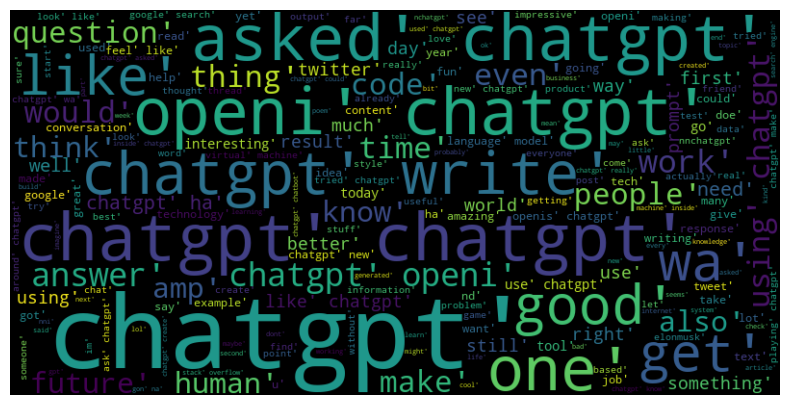

In [15]:
df['tweets'] = df['tweets'].astype(str)

text_dfs = df['tweets'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400).generate(text_dfs)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
dfnormal = df.copy()

vector = TfidfVectorizer()

tf_df_vector = vector.fit_transform(dfnormal['tweets'])
print(type(tf_df_vector), tf_df_vector.shape)

<class 'scipy.sparse._csr.csr_matrix'> (75000, 54537)


In [17]:
tf_df_array = tf_df_vector.toarray()
word_sets = vector.get_feature_names_out()

print(word_sets)

['aa' 'aaaaaa' 'aaaaaaaa' ... 'ภาษาไทย' 'เลขาchatgpt' 'ọmọ']


In [18]:
df_tf = pd.DataFrame(tf_df_array, columns=word_sets)
df_tf

,aa,aaaaaa,aaaaaaaa,aaaaaaaaaah,aaaaaaand,aaaaaand,aaaah,aaaand,aaah,aaand,...,шыв,الروبوتات,السعودية,سبحانه,وتعالى,وظيفه,દમ,ภาษาไทย,เลขาchatgpt,ọmọ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
x = tf_df_vector
y = dfnormal['labels']

near_miss_sampler = NearMiss(version=1)

X_resampled, y_resampled = near_miss_sampler.fit_resample(x, y)

In [20]:
x_train, x_test,  y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [21]:
berNB = BernoulliNB(force_alpha=True, alpha=1, binarize=.2,fit_prior=True)

berNB.fit(x_train, y_train)
    
y_pred = berNB.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6547333333333333


In [22]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         bad       0.71      0.76      0.74      4952
        good       0.69      0.63      0.66      5101
     neutral       0.56      0.57      0.57      4947

    accuracy                           0.65     15000
   macro avg       0.65      0.65      0.65     15000
weighted avg       0.65      0.65      0.65     15000



In [23]:
confusion_mat = confusion_matrix(y_test,y_pred)
print(confusion_mat)

[[3771  372  809]
 [ 498 3235 1368]
 [1040 1092 2815]]


<Axes: >

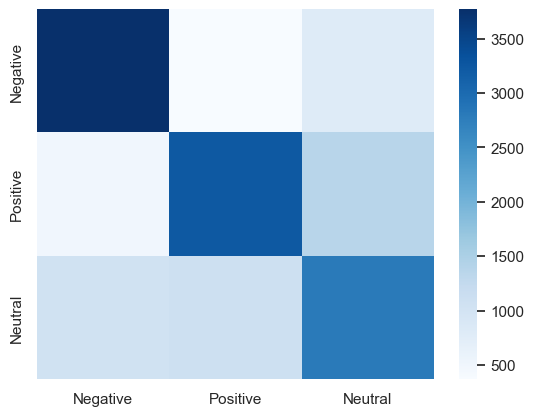

In [24]:
class_names = ["Negative", "Positive", "Neutral"]

sns.heatmap(confusion_mat, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

Berikut merupakan hasil tabel evaluasi model dengan menggunakan BernoulliNB
Tabel Evaluasi Model
Evaluasi Model
Hasil yang didapat 

Classification Report

Precision
0.71 (bad)
0.69 (good)
0.56 (neutral)

Recall
0.76 (bad)
0.63 (good)
0.57 (neutral)

F1-Score
0.74 (bad)
0.66(good)
0.57(neutral)

Support
4952 (bad)
5101 (good)
4947 (neutral)

Accuracy 0.65

Jenis Algoritma terbaik untuk Pemodelan : Bernoulli Naive Bayes

Dari uji coba yang dilakukan menggunakan data train sebanyak 80% dan test 20% dengan dataset analisis sentimen Chat GPT didapatkan nilai akurasi terbaik sebanyak 65% menggunakan jenis algoritma Bernoulli Naive Bayes dibandingkan menggunakan Multinomial Naive Bayes dan Gaussian Naive Bayes.